In [2]:
import numpy as np
import pandas as pd 
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [3]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [4]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [5]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['Root10DaysSeedling', 'Shoot10DaysSeedling', 'Root35DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot35DaysSeedling', 
                 'Root14DaysSeedling', 'Root24DaysSeedling', 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot21DaysSeedling', 'PCC', 'Shoot14DaysSeedling', 'Root52DaysSeedling', 'Shoot17DaysSeedling', 
                 'Leaf21DaysSeedling', 'log_2FoldChange', 'ET', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


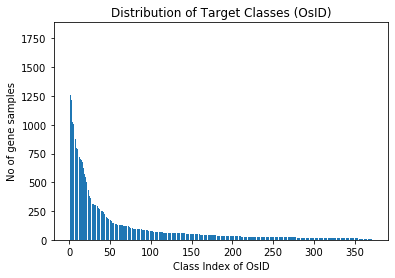

In [6]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [9]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [10]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [11]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=140, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/140
1846/1846 [==============================] - 5s 2ms/step - loss: 5.0089 - accuracy: 0.0415 - val_loss: 4.9253 - val_accuracy: 0.0750
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.5029 - accuracy: 0.0916 - val_loss: 4.2119 - val_accuracy: 0.1210
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.8938 - accuracy: 0.1430 - val_loss: 3.8504 - val_accuracy: 0.1622
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.5447 - accuracy: 0.1947 - val_loss: 3.5222 - val_accuracy: 0.2376
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2453 - accuracy: 0.2511 - val_loss: 3.2615 - val_accuracy: 0.2752
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0084 - accuracy: 0.2937 - val_loss: 3.0820 - val_accuracy: 0.2900
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8244 - accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 5.0124 - accuracy: 0.0428 - val_loss: 4.8356 - val_accuracy: 0.0964
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.3181 - accuracy: 0.1099 - val_loss: 4.1603 - val_accuracy: 0.1424
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8745 - accuracy: 0.1555 - val_loss: 3.8195 - val_accuracy: 0.1985
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.5477 - accuracy: 0.2072 - val_loss: 3.5493 - val_accuracy: 0.2315
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.2773 - accuracy: 0.2528 - val_loss: 3.3398 - val_accuracy: 0.2686
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9755 - accuracy: 0.3195 - val_loss: 3.0167 - val_accuracy: 0.3459
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.5114 - accuracy: 0.3924 - val_loss: 2.5810 - val_accuracy: 0.43

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8566 - accuracy: 0.0590 - val_loss: 4.3534 - val_accuracy: 0.0961
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.7679 - accuracy: 0.2111 - val_loss: 3.3683 - val_accuracy: 0.3032
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8234 - accuracy: 0.4061 - val_loss: 2.6782 - val_accuracy: 0.4601
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1772 - accuracy: 0.5312 - val_loss: 2.2423 - val_accuracy: 0.5483
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.7269 - accuracy: 0.6064 - val_loss: 1.9242 - val_accuracy: 0.6224
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4280 - accuracy: 0.6539 - val_loss: 1.7197 - val_accuracy: 0.6612
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2476 - accuracy: 0.6832 - val_loss: 1.6086 - val_accuracy: 0.69

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 5.0244 - accuracy: 0.0411 - val_loss: 4.8626 - val_accuracy: 0.0315
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.3966 - accuracy: 0.1170 - val_loss: 4.1874 - val_accuracy: 0.2110
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5336 - accuracy: 0.3055 - val_loss: 3.2616 - val_accuracy: 0.3545
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7183 - accuracy: 0.4251 - val_loss: 2.6413 - val_accuracy: 0.4651
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1761 - accuracy: 0.5172 - val_loss: 2.3041 - val_accuracy: 0.5395
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.8286 - accuracy: 0.5841 - val_loss: 2.0007 - val_accuracy: 0.6163
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5959 - accuracy: 0.6212 - val_loss: 1.8875 - val_accuracy: 0.62

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.6734 - accuracy: 0.0724 - val_loss: 4.1268 - val_accuracy: 0.0968
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.5637 - accuracy: 0.2673 - val_loss: 3.2961 - val_accuracy: 0.3490
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.7359 - accuracy: 0.4378 - val_loss: 2.5962 - val_accuracy: 0.5230
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.0248 - accuracy: 0.5326 - val_loss: 2.0522 - val_accuracy: 0.5734
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.5989 - accuracy: 0.6168 - val_loss: 1.8011 - val_accuracy: 0.6429
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3852 - accuracy: 0.6546 - val_loss: 1.7027 - val_accuracy: 0.6722
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.2578 - accuracy: 0.6796 - val_loss: 1.6504 - val_accuracy: 0.65

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.5883 - accuracy: 0.0726 - val_loss: 4.0316 - val_accuracy: 0.1457
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5321 - accuracy: 0.2528 - val_loss: 3.3059 - val_accuracy: 0.3595
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7876 - accuracy: 0.4388 - val_loss: 2.7198 - val_accuracy: 0.5373
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2360 - accuracy: 0.5451 - val_loss: 2.3526 - val_accuracy: 0.5793
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.8461 - accuracy: 0.6084 - val_loss: 2.0595 - val_accuracy: 0.6141
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5694 - accuracy: 0.6385 - val_loss: 1.8778 - val_accuracy: 0.6172
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3778 - accuracy: 0.6681 - val_loss: 1.7256 - val_accuracy: 0.64

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.6182 - accuracy: 0.0813 - val_loss: 4.0428 - val_accuracy: 0.1303
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4655 - accuracy: 0.2519 - val_loss: 3.1276 - val_accuracy: 0.3954
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6104 - accuracy: 0.4508 - val_loss: 2.5598 - val_accuracy: 0.4829
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0648 - accuracy: 0.5460 - val_loss: 2.1371 - val_accuracy: 0.5754
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6879 - accuracy: 0.6056 - val_loss: 1.9466 - val_accuracy: 0.6031
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4355 - accuracy: 0.6542 - val_loss: 1.7238 - val_accuracy: 0.6515
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2686 - accuracy: 0.6870 - val_loss: 1.5863 - val_accuracy: 0.67

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.3979 - accuracy: 0.0991 - val_loss: 3.8508 - val_accuracy: 0.1652
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2599 - accuracy: 0.3060 - val_loss: 2.9546 - val_accuracy: 0.3998
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.3626 - accuracy: 0.5126 - val_loss: 2.2917 - val_accuracy: 0.5758
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.7653 - accuracy: 0.6240 - val_loss: 1.8932 - val_accuracy: 0.6528
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4043 - accuracy: 0.6862 - val_loss: 1.6517 - val_accuracy: 0.7131
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.1876 - accuracy: 0.7196 - val_loss: 1.5756 - val_accuracy: 0.7043
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.0411 - accuracy: 0.7450 - val_loss: 1.4115 - val_accuracy: 0.74

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.5055 - accuracy: 0.0892 - val_loss: 4.0655 - val_accuracy: 0.1111
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5503 - accuracy: 0.2233 - val_loss: 3.3021 - val_accuracy: 0.3342
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7978 - accuracy: 0.3949 - val_loss: 2.7480 - val_accuracy: 0.4183
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2796 - accuracy: 0.5015 - val_loss: 2.3845 - val_accuracy: 0.5340
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.8797 - accuracy: 0.6022 - val_loss: 2.1326 - val_accuracy: 0.6015
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5813 - accuracy: 0.6594 - val_loss: 1.8475 - val_accuracy: 0.6477
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3547 - accuracy: 0.6948 - val_loss: 1.7103 - val_accuracy: 0.69

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.3887 - accuracy: 0.1045 - val_loss: 3.9453 - val_accuracy: 0.1637
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5643 - accuracy: 0.1872 - val_loss: 3.4929 - val_accuracy: 0.2132
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0354 - accuracy: 0.2985 - val_loss: 2.9277 - val_accuracy: 0.3969
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.3894 - accuracy: 0.4688 - val_loss: 2.4771 - val_accuracy: 0.4834
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9410 - accuracy: 0.5565 - val_loss: 2.1343 - val_accuracy: 0.5971
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6194 - accuracy: 0.6176 - val_loss: 1.8930 - val_accuracy: 0.6444
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3853 - accuracy: 0.6651 - val_loss: 1.6821 - val_accuracy: 0.67

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.5036 - accuracy: 0.0801 - val_loss: 4.1391 - val_accuracy: 0.0671
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6255 - accuracy: 0.1820 - val_loss: 3.4139 - val_accuracy: 0.2348
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7217 - accuracy: 0.4156 - val_loss: 2.4312 - val_accuracy: 0.5318
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.8610 - accuracy: 0.5921 - val_loss: 1.9050 - val_accuracy: 0.6431
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3844 - accuracy: 0.6878 - val_loss: 1.5401 - val_accuracy: 0.7001
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.1418 - accuracy: 0.7224 - val_loss: 1.3917 - val_accuracy: 0.7179
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.0038 - accuracy: 0.7437 - val_loss: 1.2826 - val_accuracy: 0.73

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.4977 - accuracy: 0.0890 - val_loss: 3.9970 - val_accuracy: 0.1199
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5372 - accuracy: 0.2149 - val_loss: 3.3339 - val_accuracy: 0.3078
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8234 - accuracy: 0.3962 - val_loss: 2.7144 - val_accuracy: 0.4469
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2372 - accuracy: 0.5102 - val_loss: 2.2460 - val_accuracy: 0.5677
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.8028 - accuracy: 0.5854 - val_loss: 1.9010 - val_accuracy: 0.6132
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4941 - accuracy: 0.6360 - val_loss: 1.7079 - val_accuracy: 0.6389
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2857 - accuracy: 0.6766 - val_loss: 1.5337 - val_accuracy: 0.68

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7050 - accuracy: 0.0685 - val_loss: 4.2067 - val_accuracy: 0.1160
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8443 - accuracy: 0.1494 - val_loss: 3.6870 - val_accuracy: 0.1745
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2625 - accuracy: 0.2632 - val_loss: 3.1184 - val_accuracy: 0.3512
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6774 - accuracy: 0.4093 - val_loss: 2.6610 - val_accuracy: 0.4794
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2426 - accuracy: 0.5118 - val_loss: 2.3409 - val_accuracy: 0.5239
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9110 - accuracy: 0.5653 - val_loss: 2.0783 - val_accuracy: 0.5844
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6493 - accuracy: 0.6039 - val_loss: 1.8711 - val_accuracy: 0.59

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.5208 - accuracy: 0.0918 - val_loss: 4.0776 - val_accuracy: 0.1465
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7288 - accuracy: 0.1768 - val_loss: 3.6312 - val_accuracy: 0.2205
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0866 - accuracy: 0.3148 - val_loss: 2.8826 - val_accuracy: 0.4119
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.4288 - accuracy: 0.4673 - val_loss: 2.4392 - val_accuracy: 0.5173
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0302 - accuracy: 0.5423 - val_loss: 2.0972 - val_accuracy: 0.5703
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.7307 - accuracy: 0.5906 - val_loss: 1.8678 - val_accuracy: 0.6119
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4997 - accuracy: 0.6349 - val_loss: 1.7225 - val_accuracy: 0.63

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.6725 - accuracy: 0.0649 - val_loss: 4.2000 - val_accuracy: 0.0944
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7627 - accuracy: 0.1598 - val_loss: 3.5976 - val_accuracy: 0.2077
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1685 - accuracy: 0.2918 - val_loss: 3.0059 - val_accuracy: 0.3837
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5325 - accuracy: 0.4563 - val_loss: 2.4921 - val_accuracy: 0.5096
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0674 - accuracy: 0.5343 - val_loss: 2.1480 - val_accuracy: 0.5516
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.7490 - accuracy: 0.5828 - val_loss: 1.9297 - val_accuracy: 0.5872
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5254 - accuracy: 0.6235 - val_loss: 1.7190 - val_accuracy: 0.62

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
1846/1846 [==============================] - 6s 2ms/step - loss: 4.7779 - accuracy: 0.0593 - val_loss: 4.2979 - val_accuracy: 0.0671
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8866 - accuracy: 0.1420 - val_loss: 3.6546 - val_accuracy: 0.2064
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1540 - accuracy: 0.3246 - val_loss: 2.9892 - val_accuracy: 0.3927
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5226 - accuracy: 0.4705 - val_loss: 2.5124 - val_accuracy: 0.5089
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0785 - accuracy: 0.5430 - val_loss: 2.1846 - val_accuracy: 0.5606
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.7639 - accuracy: 0.5959 - val_loss: 1.9260 - val_accuracy: 0.6169
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5261 - accuracy: 0.6329 - val_loss: 1.7630 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.6061 - accuracy: 0.0809 - val_loss: 4.1573 - val_accuracy: 0.1127
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7526 - accuracy: 0.1493 - val_loss: 3.6427 - val_accuracy: 0.1690
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2335 - accuracy: 0.2509 - val_loss: 3.1505 - val_accuracy: 0.3351
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6979 - accuracy: 0.4174 - val_loss: 2.6796 - val_accuracy: 0.4834
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2614 - accuracy: 0.4954 - val_loss: 2.3499 - val_accuracy: 0.4957
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9524 - accuracy: 0.5366 - val_loss: 2.1100 - val_accuracy: 0.5516
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.7355 - accuracy: 0.5670 - val_loss: 1.9339 - val_accuracy: 0.56

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7156 - accuracy: 0.0713 - val_loss: 4.2174 - val_accuracy: 0.1149
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8873 - accuracy: 0.1467 - val_loss: 3.7448 - val_accuracy: 0.1826
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4568 - accuracy: 0.2057 - val_loss: 3.3656 - val_accuracy: 0.2246
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0102 - accuracy: 0.2940 - val_loss: 2.9422 - val_accuracy: 0.3333
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5847 - accuracy: 0.3861 - val_loss: 2.5733 - val_accuracy: 0.4180
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2628 - accuracy: 0.4560 - val_loss: 2.3867 - val_accuracy: 0.4570
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0178 - accuracy: 0.5166 - val_loss: 2.1754 - val_accuracy: 0.50

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
1846/1846 [==============================] - 5s 2ms/step - loss: 4.8553 - accuracy: 0.0558 - val_loss: 4.4515 - val_accuracy: 0.0684
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.0059 - accuracy: 0.1433 - val_loss: 3.8523 - val_accuracy: 0.1685
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4856 - accuracy: 0.2263 - val_loss: 3.3740 - val_accuracy: 0.2790
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9892 - accuracy: 0.3203 - val_loss: 2.9789 - val_accuracy: 0.3331
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5515 - accuracy: 0.4075 - val_loss: 2.5857 - val_accuracy: 0.4251
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2255 - accuracy: 0.4820 - val_loss: 2.3331 - val_accuracy: 0.4937
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0002 - accuracy: 0.5230 - val_loss: 2.1400 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8759 - accuracy: 0.0547 - val_loss: 4.5896 - val_accuracy: 0.0691
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.1416 - accuracy: 0.1193 - val_loss: 3.9931 - val_accuracy: 0.1402
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6683 - accuracy: 0.1877 - val_loss: 3.6316 - val_accuracy: 0.1714
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3247 - accuracy: 0.2324 - val_loss: 3.3335 - val_accuracy: 0.2519
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9732 - accuracy: 0.2982 - val_loss: 3.0024 - val_accuracy: 0.3270
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6326 - accuracy: 0.3634 - val_loss: 2.7117 - val_accuracy: 0.3681
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.3360 - accuracy: 0.4161 - val_loss: 2.4683 - val_accuracy: 0.43

In [13]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

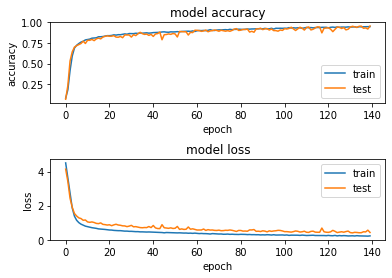

Final Test Accuracy: 0.9653571248054504


In [14]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [15]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 2s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       0.97      1.00      0.99       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


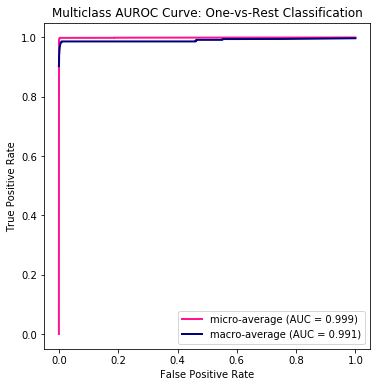

In [23]:
n_classes = 373
ohe_y_test_enc = to_categorical(y_test_enc, num_classes=373)

# Store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute ROC curve and ROC area for each class (one-vs-rest)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ohe_y_test_enc[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ohe_y_test_enc.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
valid_classes = 0 
for i in range(n_classes):
    if np.sum(ohe_y_test_enc[:, i]) > 0:  # Exclude classes with no positive samples
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        valid_classes += 1

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#Plot all OvR ROC curves together
fig, ax = plt.subplots(figsize=(8, 6))



plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average (AUC = {roc_auc['micro']:.3f})",
    color="deeppink",
    linewidth=2,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average (AUC = {roc_auc['macro']:.3f})",
    color="navy",
    linewidth=2,
)


plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass AUROC Curve: One-vs-Rest Classification")
plt.legend(loc="lower right")
plt.show()

In [24]:
import pickle

filepath = 'RBFN_auroc.pkl'
data = {'RBFN_fpr_macro': fpr['macro'],
        'RBFN_tpr_macro': tpr['macro'],
        'RBFN_auc_macro': roc_auc['macro']}

with open(filepath,'wb') as f:
    pickle.dump(data,f)

In [25]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('RBFN_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os03g0644400         328              100       False
1  Os01g0173100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [27]:
display(models_df)

,No of input features,Model accuracy
0,1,0.541
1,2,0.859
2,3,0.921
3,4,0.920
4,5,0.882
5,6,0.961
6,7,0.943
7,8,0.949
8,9,0.940
9,10,0.916
